In [1]:
%pylab inline
%config InlineBackend.figure_format = 'svg'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import astropy.cosmology as cosmo
from astropy.cosmology import Planck15
import astropy.units as u
from Corrfunc.theory.DD import DD
from Corrfunc.utils import convert_3d_counts_to_cf
import healpy as hp
import h5py
import pandas as pd
import seaborn as sns
from tqdm import tqdm

sns.set_context('notebook')
sns.set_style('ticks')
sns.set_palette('colorblind')

In [3]:
with h5py.File('better-comoving-positions.h5', 'r') as f:
    zs = array(f['zs'])
    ras = array(f['ras'])
    decs = array(f['decs'])

Here is what the detection pattern looks like on the sky:

Sigma is 1200.000000 arcmin (0.349066 rad) 
-> fwhm is 2825.784054 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


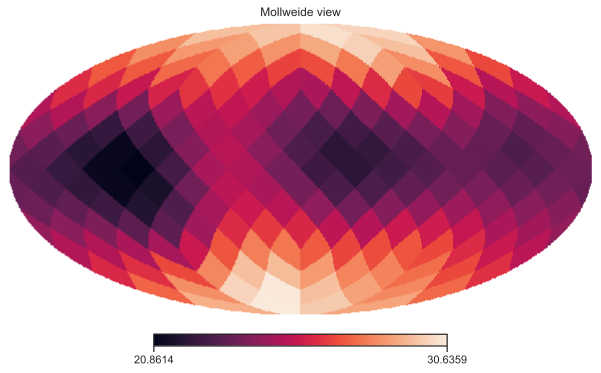

In [4]:
nside = 4
pixs = hp.ang2pix(nside, pi/2-decs, ras)
counts = bincount(pixs, minlength=hp.nside2npix(nside))
counts = hp.smoothing(counts, sigma=20*np.pi/180.0)
hp.mollview(counts)

In [5]:
dcs = Planck15.comoving_distance(zs).to(u.Gpc).value[:,newaxis]*column_stack((cos(ras)*cos(decs), sin(ras)*cos(decs), sin(decs)))
dcs = pd.DataFrame(data=dcs, columns=['x', 'y', 'z'])
nd = len(dcs)

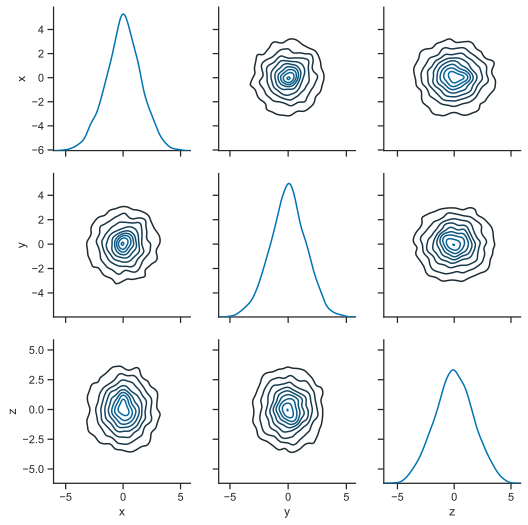

In [6]:
g = sns.PairGrid(dcs)
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot)

In [19]:
rmin = 50/1e3
rmax = 300/1e3
rbins = exp(arange(log(rmin), log(rmax), 0.1))

In [20]:
dd = DD(1, 1, rbins, dcs['x'], dcs['y'], dcs['z'])

In [21]:
Nrand = 100 # Should be 100, but to save time!
cfs = []
for i in tqdm(range(Nrand)):
    with h5py.File('better-comoving-positions-random.h5', 'r') as f:
        g = f[str(i)]
        z = array(g['zs'])
        r = array(g['ras'])
        d = array(g['decs'])
        
        p = Planck15.comoving_distance(z).to(u.Gpc).value[:,newaxis]*column_stack((cos(r)*cos(d), sin(r)*cos(d), sin(d)))
        
        dr = DD(0, 1, rbins, dcs['x'], dcs['y'], dcs['z'], X2=p[:,0], Y2=p[:,1], Z2=p[:,2])
        rr = DD(1, 1, rbins, p[:,0], p[:,1], p[:,2])
        
        cfs.append(convert_3d_counts_to_cf(len(dcs), len(dcs), p.shape[0], p.shape[0], dd, dr, dr, rr))
cfs = array(cfs)

100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


In [22]:
rmids = 0.5*(rbins[1:] + rbins[:-1])

<ErrorbarContainer object of 3 artists>

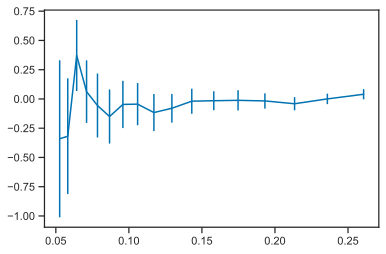

In [23]:
errorbar(rmids, mean(cfs, axis=0), yerr=std(cfs, axis=0))